# Terminal Link Optimization

This is the main ipython script for the terminal link optimization algorithm.
I will update the documentation accordingly once the project has progressed further.

## Import packages

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Make simulation of satellite and customers

Lets first start by simulating customers on the ground. This will essentially 
end up being a straight line with dots (representing customers) being randomly 
distributed along the line. The line will be spaced according to some 
arbitrary time metric. Each customer will have (for now) 4 attributes which 
describe the "importantness" of each customer.

In [0]:
"""
Lets make an array containing the physical location of some simulated customers.
The array will have the shape (N_time_segments,length_of_time_segment)

customer data array `customer_arr` will be of shape (number of training orbits, number of customers 
in orbit, number of features describing priority of customers)
"""

# training set hyperparameters
num_customers = 100 # total number of customers on planet
num_orbits = 10000  # total number of training samples (in this case orbits)
max_dist = 10000    # maximum distance allowed for customers
customer_arr = np.zeros((num_orbits,num_customers,5)) # Define emtpy array to contain customer data

# Make training set
for i in range(num_orbits):
    # Make customer index labels
    customer_arr[i,:,0] = np.arange(start=0,stop=num_customers,step=1)

    # Define random locations of customers on a line defining the planet
    customer_arr[i,:,1] = np.random.randint(low=0,high=max_dist,size=(num_customers))

    # Assign a random customer important factor. 0 == low importance, 1 == high importance
    customer_arr[i,:,2] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

    # Assign a random customer weather factor. 0 == high cloud coverage, 1 == low cloud coverage
    customer_arr[i,:,3] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

# Testing set hyperparameters
num_test_orbits = 100 # number of test samples to use
customer_test_arr = np.zeros((num_test_orbits,num_customers,5))

# Make test set
for i in range(num_test_orbits):
    # Make customer index labels
    customer_test_arr[i,:,0] = np.arange(start=0,stop=num_customers,step=1)

    # Define random locations of customers on a line defining the planet
    customer_test_arr[i,:,1] = np.random.randint(low=0,high=max_dist,size=(num_customers))

    # Assign a random customer important factor. 0 == low importance, 1 == high importance
    customer_test_arr[i,:,2] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

    # Assign a random customer weather factor. 0 == high cloud coverage, 1 == low cloud coverage
    customer_test_arr[i,:,3] = np.random.uniform(low=0.0,high=1.0,size=(num_customers))

## Choose optimal order in which to distribute keys (simple approach)

This is an incredibly simple algorithm which only takes into account 
the importantness and weather factors for each customer. It does not 
take into account the total time customers have been waiting for 
a key to be distributed to them.

In [0]:
# Loop over all available customers within line-of-sight (this is by default set to num_customers)
# This is an example using only one training orbit.
for i in range(num_customers):
    customer_arr[0,i,4] = customer_arr[0,i,2] * customer_arr[0,i,3]

customer_prob_list_idx = np.argsort(customer_arr[0,:,4])[::-1]
customer_prob_list = customer_arr[0,customer_prob_list_idx,0]

In [4]:
# Print out ordered list of customers to distribute keys to
customer_prob_list

array([38., 72., 22., 61.,  4.,  3., 25., 83., 99., 57., 56., 76., 20.,
       59., 48., 42., 67., 91., 90., 60., 27., 96.,  7., 40., 43., 47.,
       36., 29., 71.,  8., 81., 51.,  9., 21., 18.,  5., 88., 87.,  0.,
       82., 26., 78., 37., 66., 98., 13., 45., 14., 35., 92., 80., 74.,
       77., 75., 41., 52., 17., 30., 44., 32., 58., 86.,  1., 31., 79.,
       97.,  6., 54., 28., 89., 50., 64., 34., 46., 70., 63., 15., 65.,
       10., 94., 85., 69., 68., 11., 12., 95., 19., 55., 33.,  2., 24.,
       53., 62., 93., 23., 16., 84., 73., 39., 49.])

## Neural Network Approach (complicated approach)

I've written some pseudo code down on a piece of paper. Not guranteeing that 
this will actually work in practice, but I will make my first attempt of this here.

### Define network archetecture

In [11]:
# This approach uses the Pytorch neural network library

# neural network hyperparameters
number_epochs = 100
batch_size = 128

# Define network archetecture (convolutional neural network)
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (1,3), stride=1).double()
        self.conv2 = nn.Conv2d(32, 64, (1,3), stride=1).double()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(6144, 120).double()
        self.fc2 = nn.Linear(120, 84).double()
        self.fc3 = nn.Linear(84, num_customers).double() # one node for predicted probability

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        # If the size is a square you can only specify a single number
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.num_flat_features(x))
        # Two fully-connected hidden layers and one output layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
net.to(device)
print(net)

params = list(net.parameters())

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(1, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1))
  (fc1): Linear(in_features=6144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=100, bias=True)
)


Need to fix loss function, such that it is differentiable. This can be done by 
scaling the loss calculated for each customer by the predicted probability 
associated with each customer. See picture on your phone for more details.


In [0]:
def custom_loss(output, target, batch_feature_data):
    """ This is a custom loss function which 
    takes as input the raw output from the neural 
    network and returns a loss which attempts to 
    minimize the number of keys not distributed 
    within the alloted amount of time.
    """
    
    def my_model(output, batch_feature_data):
        """ This is a model which will iterate 
        over the predicted ordering of keys to be 
        distributed. There will be a penalty 
        associated with any keys which are predicted to 
        be distributed outside of the obersvation window.
        """

        # Assume 5 seconds to distribute key to customer downstream
        # Array to store the calculated number of keys lying outside of time alloted
        new_output = torch.zeros((batch_feature_data.shape[0],1), requires_grad=True)

        # Iterate over all samples in batch
        for i in range(batch_feature_data.shape[0]):

          # Sort predicted output sample by probability from high to low
          tmp_output = torch.sort(output[i,:])[::-1]

          # Iterate through probability preds for 1 sample from high to low
          dist_cnt = 0              # Initialize distance traveled to be zero
          sat_over_horizon = False  # If True, satellite has started going out of reach
          num_outside_batch = 0
          for j in range(num_customers):

            # Once satellite goes over horizon, start dropping customers
            if dist_cnt >= max_dist:
              dist_cnt = 0             # Reset distance counter
              sat_over_horizon = True  # set satellite to now be over horizon
            
            if sat_over_horizon == True:
              if batch_feature_data[i,j,0] < dist_cnt:
                num_outside_batch += 1
                # Add penalty associated with importantness and weather
                new_output[i,0] += (batch_feature_data[i,j,1] + 
                                    batch_feature_data[i,j,2])

            # Add a distance traveled by satellite
            dist_cnt += 200
#          print('Found %d cutomers outside of batch' % num_outside_batch)
    
        return torch.tensor(new_output, requires_grad=True)
    
    # Get number of keys predicted to be outside of target window
    pred_model_score = my_model(output, batch_feature_data)
    
    loss = torch.mean((pred_model_score - torch.tensor(target, requires_grad=True))**2)
    return loss

### Run network over entire training set

In [0]:
# training features: location, importance, weather
X_train = customer_arr[:,:,1:4]
Y_train = np.zeros((num_orbits,1))

In [14]:
running_loss = 0.0
train_split = num_orbits

dset_train = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
dataloader = DataLoader(dset_train, batch_size=batch_size,
                        shuffle=True)

# Iterate over entire training set
for epoch_num in range(number_epochs):
    for i_batch, sampled_batch in enumerate(dataloader):
        # in your training loop:
        if (train_split - (batch_size * i_batch)) < batch_size:
            break
        optimizer.zero_grad()   # zero the gradient buffers
        output = net(sampled_batch[0].reshape(batch_size,3,1,num_customers).to(device))
        loss = custom_loss(output, Y_train[i_batch:i_batch+batch_size].reshape(batch_size,1), sampled_batch[0])
        loss.backward()
        optimizer.step()    # Does the update to the network
        #print('Finished a batch')    
        
    
    
    print('Training epoch %d/%d' % (epoch_num+1,number_epochs))
    # print statistics
    print('loss: %.3f' %
          (loss.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training epoch 1/100
loss: 642.651
Training epoch 2/100
loss: 599.185
Training epoch 3/100
loss: 607.685


KeyboardInterrupt: ignored

### Plot Results

In [15]:
# Get test predictions from trained neural network
test_preds = net(torch.tensor(customer_test_arr[:,:,1:4].reshape(num_test_orbits,3,1,num_customers)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [65]:
print(test_preds)

tensor([[3.8573e-15, 1.0000e+00, 1.3726e-26,  ..., 1.2171e-15, 5.3628e-12,
         1.0000e+00],
        [5.4367e-15, 5.8845e-08, 9.6777e-20,  ..., 1.6934e-14, 5.6693e-20,
         1.0000e+00],
        [2.0212e-13, 1.0000e+00, 1.9437e-15,  ..., 1.2995e-23, 4.2252e-12,
         1.0000e+00],
        ...,
        [3.5185e-28, 1.0000e+00, 7.6185e-32,  ..., 1.0770e-06, 1.3041e-12,
         1.0000e+00],
        [6.7350e-08, 1.0000e+00, 2.8434e-16,  ..., 1.5455e-09, 1.9735e-12,
         1.0000e+00],
        [2.4229e-20, 9.9916e-01, 1.6175e-32,  ..., 8.1845e-31, 1.1222e-02,
         9.1716e-01]], dtype=torch.float64, grad_fn=<SigmoidBackward>)


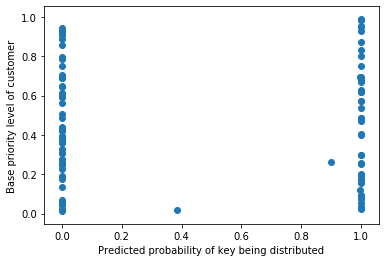

In [16]:
# Make scatter plot of priority as a function of key dist probability
plt.scatter(test_preds[0,:].detach().numpy(),customer_test_arr[0,:,2])
plt.xlabel('Predicted probability of key being distributed')
plt.ylabel('Base priority level of customer')
plt.show()